<a href="https://colab.research.google.com/github/tushar-semwal/fedperf/blob/main/Santiago/Shakespeare/FedProx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FedPerf - Shakespeare + FedProx algorithm

## Setup & Dependencies Installation

In [ ]:
%%capture
!pip install torchsummaryX unidecode

In [ ]:
%load_ext tensorboard

import copy
from functools import reduce
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import time
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import Sampler
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from torchsummaryX import summary as summaryx
from torchvision import transforms, utils, datasets
from tqdm.notebook import tqdm
from unidecode import unidecode

%matplotlib inline

# Check assigned GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

# set manual seed for reproducibility
RANDOM_SEED = 42

# general reproducibility
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

# gpu training specific
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Tue May  4 18:52:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Mount GDrive

In [ ]:
BASE_DIR = '/content/drive/MyDrive/FedPerf/shakespeare/FedProx'

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    os.makedirs(BASE_DIR, exist_ok=True)
except:
    print("WARNING: Results won't be stored on GDrive")
    BASE_DIR = './'



Mounted at /content/drive


## Loading Dataset

In [ ]:
!rm -Rf data
!mkdir -p data scripts

In [ ]:
GENERATE_DATASET = False  # If False, download the dataset provided by the q-FFL paper
DATA_DIR = 'data/'
# Dataset generation params
SAMPLES_FRACTION = 1.  # If using an already generated dataset
# SAMPLES_FRACTION = 0.2  # Fraction of total samples in the dataset - FedProx default script
# SAMPLES_FRACTION = 0.05  # Fraction of total samples in the dataset - qFFL
TRAIN_FRACTION = 0.8  # Train set size
MIN_SAMPLES = 0  # Min samples per client (for filtering purposes) - FedProx
# MIN_SAMPLES = 64  # Min samples per client (for filtering purposes) - qFFL

In [ ]:
# Download raw dataset
# !wget https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt -O data/shakespeare.txt
!wget --adjust-extension http://www.gutenberg.org/files/100/100-0.txt -O data/shakespeare.txt

--2021-05-04 18:52:31--  http://www.gutenberg.org/files/100/100-0.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.gutenberg.org/files/100/100-0.txt [following]
--2021-05-04 18:52:31--  https://www.gutenberg.org/files/100/100-0.txt
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5757108 (5.5M) [text/plain]
Saving to: ‘data/shakespeare.txt’

data/shakespeare.tx 100%[===================>]   5.49M  --.-KB/s    in 0.1s    

2021-05-04 18:52:32 (46.1 MB/s) - ‘data/shakespeare.txt’ saved [5757108/5757108]



In [ ]:
if not GENERATE_DATASET:
    !rm -Rf data/train data/test
    !gdown --id 1n46Mftp3_ahRi1Z6jYhEriyLtdRDS1tD  # Download Shakespeare dataset used by the FedProx paper
    !unzip shakespeare.zip
    !mv -f shakespeare_paper/train data/
    !mv -f shakespeare_paper/test data/
    !rm -R shakespeare_paper/ shakespeare.zip


Downloading...
From: https://drive.google.com/uc?id=1n46Mftp3_ahRi1Z6jYhEriyLtdRDS1tD
To: /content/shakespeare.zip
2.96MB [00:00, 26.1MB/s]
Archive:  shakespeare.zip
   creating: shakespeare_paper/
   creating: shakespeare_paper/test/
  inflating: shakespeare_paper/test/all_data_niid_2_keep_0_test_8.json  
   creating: shakespeare_paper/train/
  inflating: shakespeare_paper/train/all_data_niid_2_keep_0_train_8.json  


In [ ]:
corpus = []
with open('data/shakespeare.txt', 'r') as f:
    data = list(unidecode(f.read()))
    corpus = list(set(list(data)))
print('Corpus Length:', len(corpus))

Corpus Length: 90


#### Dataset Preprocessing script

In [ ]:
%%capture
if GENERATE_DATASET:
    # Download dataset generation scripts
    !wget https://raw.githubusercontent.com/ml-lab/FedProx/master/data/shakespeare/preprocess/preprocess_shakespeare.py -O scripts/preprocess_shakespeare.py
    !wget https://raw.githubusercontent.com/ml-lab/FedProx/master/data/shakespeare/preprocess/shake_utils.py -O scripts/shake_utils.py
    !wget https://raw.githubusercontent.com/ml-lab/FedProx/master/data/shakespeare/preprocess/gen_all_data.py -O scripts/gen_all_data.py

    # Download data preprocessing scripts
    !wget https://raw.githubusercontent.com/ml-lab/FedProx/master/utils/sample.py -O scripts/sample.py
    !wget https://raw.githubusercontent.com/ml-lab/FedProx/master/utils/remove_users.py -O scripts/remove_users.py

In [ ]:
# Running scripts
if GENERATE_DATASET:
    !mkdir -p data/raw_data data/all_data data/train data/test
    !python scripts/preprocess_shakespeare.py data/shakespeare.txt data/raw_data
    !python scripts/gen_all_data.py

#### Dataset class

In [ ]:
class ShakespeareDataset(Dataset):
    def __init__(self, x, y, corpus, seq_length):
        self.x = x
        self.y = y
        self.corpus = corpus
        self.corpus_size = len(self.corpus)
        super(ShakespeareDataset, self).__init__()

    def __len__(self):
        return len(self.x)

    def __repr__(self):
        return f'{self.__class__} - (length: {self.__len__()})'

    def __getitem__(self, i):
        input_seq = self.x[i]
        next_char = self.y[i]
        # print('\tgetitem', i, input_seq, next_char)
        input_value = self.text2charindxs(input_seq)
        target_value = self.get_label_from_char(next_char)
        return input_value, target_value

    def text2charindxs(self, text):
        tensor = torch.zeros(len(text), dtype=torch.int32)
        for i, c in enumerate(text):
            tensor[i] = self.get_label_from_char(c)
        return tensor

    def get_label_from_char(self, c):
        return self.corpus.index(c)

    def get_char_from_label(self, l):
        return self.corpus[l]

##### Federated Dataset

In [ ]:
class ShakespeareFedDataset(ShakespeareDataset):
    def __init__(self, x, y, corpus, seq_length):
        super(ShakespeareFedDataset, self).__init__(x, y, corpus, seq_length)

    def dataloader(self, batch_size, shuffle=True):
        return DataLoader(self,
                          batch_size=batch_size,
                          shuffle=shuffle,
                          num_workers=0)


## Partitioning & Data Loaders

### IID

In [ ]:
def iid_partition_(dataset, clients):
  """
  I.I.D paritioning of data over clients
  Shuffle the data
  Split it between clients
  
  params:
    - dataset (torch.utils.Dataset): Dataset
    - clients (int): Number of Clients to split the data between

  returns:
    - Dictionary of image indexes for each client
  """

  num_items_per_client = int(len(dataset)/clients)
  client_dict = {}
  image_idxs = [i for i in range(len(dataset))]

  for i in range(clients):
    client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
    image_idxs = list(set(image_idxs) - client_dict[i])

  return client_dict

In [ ]:
def iid_partition(corpus, seq_length=80, val_split=False):

    train_file = [os.path.join(DATA_DIR, 'train', f) for f in os.listdir(f'{DATA_DIR}/train') if f.endswith('.json')][0]
    test_file = [os.path.join(DATA_DIR, 'test', f) for f in os.listdir(f'{DATA_DIR}/test') if f.endswith('.json')][0]

    with open(train_file, 'r') as file:
        data_train = json.loads(unidecode(file.read()))

    with open(test_file, 'r') as file:
        data_test = json.loads(unidecode(file.read()))

    
    total_samples_train = sum(data_train['num_samples'])

    data_dict = {}

    x_train, y_train = [], []
    x_test, y_test = [], []
    # x_val, y_val = [], []

    users = list(zip(data_train['users'], data_train['num_samples']))
    # random.shuffle(users)



    total_samples = int(sum(data_train['num_samples']) * SAMPLES_FRACTION)
    print('Objective', total_samples, '/', sum(data_train['num_samples']))
    sample_count = 0
    
    for i, (author_id, samples) in enumerate(users):

        if sample_count >= total_samples:
            print('Max samples reached', sample_count, '/', total_samples)
            break

        if samples < MIN_SAMPLES: # or data_train['num_samples'][i] > 10000:
            print('SKIP', author_id, samples)
            continue
        else:
            udata_train = data_train['user_data'][author_id]
            max_samples = samples if (sample_count + samples) <= total_samples else (sample_count + samples - total_samples) 
            
            sample_count += max_samples
            # print('sample_count', sample_count)

            x_train.extend(data_train['user_data'][author_id]['x'][:max_samples])
            y_train.extend(data_train['user_data'][author_id]['y'][:max_samples])

            author_data = data_test['user_data'][author_id]
            test_size = int(len(author_data['x']) * SAMPLES_FRACTION)

            if val_split:
                x_test.extend(author_data['x'][:int(test_size / 2)])
                y_test.extend(author_data['y'][:int(test_size / 2)])
                # x_val.extend(author_data['x'][int(test_size / 2):])
                # y_val.extend(author_data['y'][int(test_size / 2):int(test_size)])

            else:
                x_test.extend(author_data['x'][:int(test_size)])
                y_test.extend(author_data['y'][:int(test_size)])

    train_ds = ShakespeareDataset(x_train, y_train, corpus, seq_length)
    test_ds = ShakespeareDataset(x_test, y_test, corpus, seq_length)
    # val_ds = ShakespeareDataset(x_val, y_val, corpus, seq_length)

    data_dict = iid_partition_(train_ds, clients=len(users))

    return train_ds, data_dict, test_ds

### Non-IID

In [ ]:
def noniid_partition(corpus, seq_length=80, val_split=False):

    train_file = [os.path.join(DATA_DIR, 'train', f) for f in os.listdir(f'{DATA_DIR}/train') if f.endswith('.json')][0]
    test_file = [os.path.join(DATA_DIR, 'test', f) for f in os.listdir(f'{DATA_DIR}/test') if f.endswith('.json')][0]

    with open(train_file, 'r') as file:
        data_train = json.loads(unidecode(file.read()))

    with open(test_file, 'r') as file:
        data_test = json.loads(unidecode(file.read()))

    
    total_samples_train = sum(data_train['num_samples'])

    data_dict = {}

    x_test, y_test = [], []

    users = list(zip(data_train['users'], data_train['num_samples']))
    # random.shuffle(users)

    total_samples = int(sum(data_train['num_samples']) * SAMPLES_FRACTION)
    print('Objective', total_samples, '/', sum(data_train['num_samples']))
    sample_count = 0
    
    for i, (author_id, samples) in enumerate(users):

        if sample_count >= total_samples:
            print('Max samples reached', sample_count, '/', total_samples)
            break

        if samples < MIN_SAMPLES: # or data_train['num_samples'][i] > 10000:
            print('SKIP', author_id, samples)
            continue
        else:
            udata_train = data_train['user_data'][author_id]
            max_samples = samples if (sample_count + samples) <= total_samples else (sample_count + samples - total_samples) 
            
            sample_count += max_samples
            # print('sample_count', sample_count)

            x_train = data_train['user_data'][author_id]['x'][:max_samples]
            y_train = data_train['user_data'][author_id]['y'][:max_samples]

            train_ds = ShakespeareFedDataset(x_train, y_train, corpus, seq_length)

            x_val, y_val = None, None
            val_ds = None
            author_data = data_test['user_data'][author_id]
            test_size = int(len(author_data['x']) * SAMPLES_FRACTION)
            if val_split:
                x_test += author_data['x'][:int(test_size / 2)]
                y_test += author_data['y'][:int(test_size / 2)]
                x_val = author_data['x'][int(test_size / 2):]
                y_val = author_data['y'][int(test_size / 2):int(test_size)]

                val_ds = ShakespeareFedDataset(x_val, y_val, corpus, seq_length)

            else:
                x_test += author_data['x'][:int(test_size)]
                y_test += author_data['y'][:int(test_size)]

            data_dict[author_id] = {
                'train_ds': train_ds,
                'val_ds': val_ds
            }

    test_ds = ShakespeareFedDataset(x_test, y_test, corpus, seq_length)

    return data_dict, test_ds

## Models

### Shakespeare LSTM

In [ ]:
class ShakespeareLSTM(nn.Module):
    """
    """

    def __init__(self, input_dim, embedding_dim, hidden_dim, classes, lstm_layers=2, dropout=0.1, batch_first=True):
        super(ShakespeareLSTM, self).__init__()
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.classes = classes
        self.no_layers = lstm_layers
        
        self.embedding = nn.Embedding(num_embeddings=self.classes,
                                      embedding_dim=self.embedding_dim)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, 
                            hidden_size=self.hidden_dim,
                            num_layers=self.no_layers,
                            batch_first=batch_first, 
                            dropout=dropout if self.no_layers > 1 else 0.)
        self.fc = nn.Linear(hidden_dim, self.classes)

    def forward(self, x, hc=None):
        batch_size = x.size(0)
        x_emb = self.embedding(x)
        out, (ht, ct) = self.lstm(x_emb.view(batch_size, -1, self.embedding_dim), hc)
        dense = self.fc(ht[-1])
        return dense
    
    def init_hidden(self, batch_size):
        return (Variable(torch.zeros(self.no_layers, batch_size, self.hidden_dim)),
                Variable(torch.zeros(self.no_layers, batch_size, self.hidden_dim)))


#### Model Summary

In [ ]:
batch_size = 10
seq_length = 80 # mcmahan17a, fedprox, qFFL

shakespeare_lstm = ShakespeareLSTM(input_dim=seq_length,  
                                   embedding_dim=8,  # mcmahan17a, fedprox, qFFL
                                   hidden_dim=256,  # mcmahan17a, fedprox impl
                                #    hidden_dim=100,  # fedprox paper
                                   classes=len(corpus),
                                   lstm_layers=2,
                                   dropout=0.1,  # TODO:
                                   batch_first=True
                                   )

if torch.cuda.is_available():
  shakespeare_lstm.cuda()



hc = shakespeare_lstm.init_hidden(batch_size)

x_sample = torch.zeros((batch_size, seq_length),
                       dtype=torch.long,
                       device=(torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')))

x_sample[0][0] = 1
x_sample

print("\nShakespeare LSTM SUMMARY")
print(summaryx(shakespeare_lstm, x_sample))


Shakespeare LSTM SUMMARY
            Kernel Shape   Output Shape  Params  Mult-Adds
Layer                                                     
0_embedding      [8, 90]    [10, 80, 8]     720        720
1_lstm                 -  [10, 80, 256]  798720     794624
2_fc           [256, 90]       [10, 90]   23130      23040
----------------------------------------------------------
                      Totals
Total params          822570
Trainable params      822570
Non-trainable params       0
Mult-Adds             818384
            Kernel Shape   Output Shape  Params  Mult-Adds
Layer                                                     
0_embedding      [8, 90]    [10, 80, 8]     720        720
1_lstm                 -  [10, 80, 256]  798720     794624
2_fc           [256, 90]       [10, 90]   23130      23040


## FedProx Algorithm

### Plot Utils

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
def plot_scores(history, exp_id, title, suffix):
    accuracies = [x['accuracy'] for x in history]
    f1_macro = [x['f1_macro'] for x in history]
    f1_weighted = [x['f1_weighted'] for x in history]

    fig, ax = plt.subplots()
    ax.plot(accuracies, 'tab:orange')
    ax.set(xlabel='Rounds', ylabel='Test Accuracy', title=title)
    ax.grid()
    fig.savefig(f'{BASE_DIR}/{exp_id}/Test_Accuracy_{suffix}.jpg', format='jpg', dpi=300)
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(f1_macro, 'tab:orange')
    ax.set(xlabel='Rounds', ylabel='Test F1 (macro)', title=title)
    ax.grid()
    fig.savefig(f'{BASE_DIR}/{exp_id}/Test_F1_Macro_{suffix}.jpg', format='jpg')
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(f1_weighted, 'tab:orange')
    ax.set(xlabel='Rounds', ylabel='Test F1 (weighted)', title=title)
    ax.grid()
    fig.savefig(f'{BASE_DIR}/{exp_id}/Test_F1_Weighted_{suffix}.jpg', format='jpg')
    plt.show()


def plot_losses(history, exp_id, title, suffix):
    val_losses = [x['loss'] for x in history]
    train_losses = [x['train_loss'] for x in history]

    fig, ax = plt.subplots()
    ax.plot(train_losses, 'tab:orange')
    ax.set(xlabel='Rounds', ylabel='Train Loss', title=title)
    ax.grid()
    fig.savefig(f'{BASE_DIR}/{exp_id}/Train_Loss_{suffix}.jpg', format='jpg')
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(val_losses, 'tab:orange')
    ax.set(xlabel='Rounds', ylabel='Test Loss', title=title)
    ax.grid()
    fig.savefig(f'{BASE_DIR}/{exp_id}/Test_Loss_{suffix}.jpg', format='jpg')
    plt.show()


### Systems Heterogeneity Simulations

Generate epochs for selected clients based on percentage of devices that corresponds to heterogeneity. 

Assign x number of epochs (chosen unifirmly at random between [1, E]) to 0%, 50% or 90% of the selected devices, respectively. Settings where 0% devices perform fewer than E epochs of work correspond to the environments without system heterogeneity, while 90% of the devices sending their partial solutions corresponds to highly heterogenous system.

In [ ]:
def GenerateLocalEpochs(percentage, size, max_epochs):
  ''' Method generates list of epochs for selected clients
  to replicate system heteroggeneity

  Params:
    percentage: percentage of clients to have fewer than E epochs
    size:       total size of the list
    max_epochs: maximum value for local epochs
  
  Returns:
    List of size epochs for each Client Update

  '''

  # if percentage is 0 then each client runs for E epochs
  if percentage == 0:
      return np.array([max_epochs]*size)
  else:
    # get the number of clients to have fewer than E epochs
    heterogenous_size = int((percentage/100) * size)

    # generate random uniform epochs of heterogenous size between 1 and E
    epoch_list = np.random.randint(1, max_epochs, heterogenous_size)

    # the rest of the clients will have E epochs
    remaining_size = size - heterogenous_size
    rem_list = [max_epochs]*remaining_size

    epoch_list = np.append(epoch_list, rem_list, axis=0)
    
    # shuffle the list and return
    np.random.shuffle(epoch_list)

    return epoch_list

### Local Training (Client Update)

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, dataset, idxs):
      self.dataset = dataset
      self.idxs = list(idxs)

  def __len__(self):
      return len(self.idxs)

  def __getitem__(self, item):
      data, label = self.dataset[self.idxs[item]]
      return data, label

In [ ]:
class ClientUpdate(object):
  def __init__(self, dataset, batchSize, learning_rate, epochs, idxs, mu, algorithm):
    # self.train_loader = DataLoader(CustomDataset(dataset, idxs), batch_size=batchSize, shuffle=True)
    if hasattr(dataset, 'dataloader'):
        self.train_loader = dataset.dataloader(batch_size=batch_size, shuffle=True)
    else:
        self.train_loader = DataLoader(CustomDataset(dataset, idxs), batch_size=batch_size, shuffle=True)

    self.algorithm = algorithm
    self.learning_rate = learning_rate
    self.epochs = epochs
    self.mu = mu

  def train(self, model):
    # print("Client training for {} epochs.".format(self.epochs))
    criterion = nn.CrossEntropyLoss()
    proximal_criterion = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate, momentum=0.5)

    # use the weights of global model for proximal term calculation
    global_model = copy.deepcopy(model)

    # calculate local training time
    start_time = time.time()


    e_loss = []
    for epoch in range(1, self.epochs+1):

      train_loss = 0.0

      model.train()
      for data, labels in self.train_loader:

        if torch.cuda.is_available():
          data, labels = data.cuda(), labels.cuda()

        # clear the gradients
        optimizer.zero_grad()
        # make a forward pass
        output = model(data)

        # calculate the loss + the proximal term
        _, pred = torch.max(output, 1)

        if self.algorithm == 'fedprox':
          proximal_term = 0.0

          # iterate through the current and global model parameters
          for w, w_t in zip(model.parameters(), global_model.parameters()) :
            # update the proximal term 
            #proximal_term += torch.sum(torch.abs((w-w_t)**2))
            proximal_term += (w-w_t).norm(2)

          loss = criterion(output, labels) + (self.mu/2)*proximal_term
        else:
          loss = criterion(output, labels)
    
        # do a backwards pass
        loss.backward()
        # perform a single optimization step
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

      # average losses
      train_loss = train_loss/len(self.train_loader.dataset)
      e_loss.append(train_loss)

    total_loss = sum(e_loss)/len(e_loss)

    return model.state_dict(), total_loss, (time.time() - start_time)

### Server Side Training

In [ ]:
def training(model, rounds, batch_size, lr, ds, data_dict, test_ds, C, K, E, mu, percentage, plt_title, plt_color, target_test_accuracy,
             classes, algorithm="fedprox", history=[], eval_every=1, tb_logger=None, M=0.1):
  """
  Function implements the Federated Averaging Algorithm from the FedAvg paper.
  Specifically, this function is used for the server side training and weight update

  Params:
    - model:           PyTorch model to train
    - rounds:          Number of communication rounds for the client update
    - batch_size:      Batch size for client update training
    - lr:              Learning rate used for client update training
    - ds:              Dataset used for training
    - data_dict:       Type of data partition used for training (IID or non-IID)
    - test_data_dict:  Data used for testing the model
    - C:               Fraction of clients randomly chosen to perform computation on each round
    - K:               Total number of clients
    - E:               Number of training passes each client makes over its local dataset per round
    - mu:              proximal term constant
    - percentage:      percentage of selected client to have fewer than E epochs
  Returns:
    - model:           Trained model on the server
  """

  start = time.time()

  # global model weights
  global_weights = model.state_dict()

  # training loss
  train_loss = []

  # test accuracy
  test_acc = []

  # store last loss for convergence
  last_loss = 0.0

  # total time taken 
  total_time = 0

  print(f"System heterogeneity set to {percentage}% stragglers.\n")
  print(f"Picking {max(int(C*K),1 )} random clients per round.\n")

  users_id = list(data_dict.keys())

  for curr_round in range(1, rounds+1):
    w, local_loss, lst_local_train_time = [], [], []

    m = max(int(C*K), 1)

    heterogenous_epoch_list = GenerateLocalEpochs(percentage, size=m, max_epochs=E)
    heterogenous_epoch_list = np.array(heterogenous_epoch_list)
    # print('heterogenous_epoch_list', len(heterogenous_epoch_list))

    S_t = np.random.choice(range(K), m, replace=False)
    S_t = np.array(S_t)
    print('Clients: {}/{} -> {}'.format(len(S_t), K, S_t))
    
    # For Federated Averaging, drop all the clients that are stragglers
    if algorithm == 'fedavg':
      stragglers_indices = np.argwhere(heterogenous_epoch_list < E)
      heterogenous_epoch_list = np.delete(heterogenous_epoch_list, stragglers_indices)
      S_t = np.delete(S_t, stragglers_indices)
    c = 0
    # for _, (k, epoch) in tqdm(enumerate(zip(S_t, heterogenous_epoch_list))):
    for i in tqdm(range(len(S_t))):
    #   print('k', k)
      k = S_t[i]
      epoch = heterogenous_epoch_list[i]
      key = users_id[k]
      ds_ = ds if ds else data_dict[key]['train_ds']
      idxs = data_dict[key] if ds else None
    #   print(f'Client {k}: {len(idxs) if idxs else len(ds_)} samples')
      local_update = ClientUpdate(dataset=ds_, batchSize=batch_size, learning_rate=lr, epochs=epoch, idxs=idxs, mu=mu, algorithm=algorithm)
      weights, loss, local_train_time = local_update.train(model=copy.deepcopy(model))
    #   print(f'Local train time for {k} on {len(idxs) if idxs else len(ds_)} samples: {local_train_time}')
    #   print(f'Local train time: {local_train_time}')

      if c < int(m*M):
        for k in weights.keys():
          t = torch.Tensor(weights[k].shape).cuda()
          t.fill_(0.1)
          weights[k] = t

      w.append(copy.deepcopy(weights))
      local_loss.append(copy.deepcopy(loss))
      lst_local_train_time.append(local_train_time)

    # calculate time to update the global weights
    global_start_time = time.time()

    # updating the global weights
    weights_avg = copy.deepcopy(w[0])
    for k in weights_avg.keys():
      for i in range(1, len(w)):
        weights_avg[k] += w[i][k]

      weights_avg[k] = torch.div(weights_avg[k], len(w))

    global_weights = weights_avg

    global_end_time = time.time()

    # calculate total time 
    total_time += (global_end_time - global_start_time) + sum(lst_local_train_time)/len(lst_local_train_time)

    # move the updated weights to our model state dict
    model.load_state_dict(global_weights)

    # loss
    loss_avg = sum(local_loss) / len(local_loss)
    print('Round: {}... \tAverage Loss: {}'.format(curr_round, round(loss_avg, 3)))
    train_loss.append(loss_avg)
    if tb_logger:
        tb_logger.add_scalar(f'Train/Loss', loss_avg, curr_round)

    # testing
    # if curr_round % eval_every == 0:
    test_scores = testing(model, test_ds, batch_size * 2, nn.CrossEntropyLoss(), len(classes), classes)
    test_scores['train_loss'] = loss_avg
    test_loss, test_accuracy = test_scores['loss'], test_scores['accuracy']
    history.append(test_scores)
    
    # print('Round: {}... \tAverage Loss: {} \tTest Loss: {} \tTest Acc: {}'.format(curr_round, round(loss_avg, 3), round(test_loss, 3), round(test_accuracy, 3)))

    if tb_logger:
        tb_logger.add_scalar(f'Test/Loss', test_scores['loss'], curr_round)
        tb_logger.add_scalars(f'Test/Scores', {
            'accuracy': test_scores['accuracy'], 'f1_macro': test_scores['f1_macro'], 'f1_weighted': test_scores['f1_weighted']
        }, curr_round)

    test_acc.append(test_accuracy)
    # break if we achieve the target test accuracy
    if test_accuracy >= target_test_accuracy:
      rounds = curr_round
      break

    # break if we achieve convergence, i.e., loss between two consecutive rounds is <0.0001
    if algorithm == 'fedprox' and abs(loss_avg - last_loss) < 1e-5:
      rounds = curr_round
      break
    
    # update the last loss
    last_loss = loss_avg

  end = time.time()
  
  # plot train loss
  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(train_loss)
  ax.plot(x_axis, y_axis)

  ax.set(xlabel='Number of Rounds', ylabel='Train Loss', title=plt_title)
  ax.grid()
  # fig.savefig(plt_title+'.jpg', format='jpg')

  # plot test accuracy
  fig1, ax1 = plt.subplots()
  x_axis1 = np.arange(1, rounds+1)
  y_axis1 = np.array(test_acc)
  ax1.plot(x_axis1, y_axis1)

  ax1.set(xlabel='Number of Rounds', ylabel='Test Accuracy', title=plt_title)
  ax1.grid()
  # fig1.savefig(plt_title+'-test.jpg', format='jpg')
  
  print("Training Done! Total time taken to Train: {}".format(end-start))

  return model, history

### Testing Loop

In [ ]:
def testing(model, dataset, bs, criterion, num_classes, classes, print_all=False):
  #test loss 
  test_loss = 0.0
  correct_class = list(0. for i in range(num_classes))
  total_class = list(0. for i in range(num_classes))

  test_loader = DataLoader(dataset, batch_size=bs)
  l = len(test_loader)
  model.eval()
  print('running validation...')
  for i, (data, labels) in enumerate(tqdm(test_loader)):

    if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()

    output = model(data)
    loss = criterion(output, labels)
    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, 1)

    # For F1Score
    y_true = np.append(y_true, labels.data.view_as(pred).cpu().numpy()) if i != 0 else labels.data.view_as(pred).cpu().numpy()
    y_hat = np.append(y_hat, pred.cpu().numpy()) if i != 0 else pred.cpu().numpy()

    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())

    #test accuracy for each object class
    # for i in range(num_classes):
    #   label = labels.data[i]
    #   correct_class[label] += correct[i].item()
    #   total_class[label] += 1

    for i, lbl in enumerate(labels.data):
    #   print('lbl', i, lbl)
      correct_class[lbl] += correct.data[i]
      total_class[lbl] += 1
    
  # avg test loss
  test_loss = test_loss/len(test_loader.dataset)
  print("Test Loss: {:.6f}\n".format(test_loss))

  # Avg F1 Score
  f1_macro = f1_score(y_true, y_hat, average='macro')
  # F1-Score -> weigthed to consider class imbalance
  f1_weighted =  f1_score(y_true, y_hat, average='weighted')
  print("F1 Score: {:.6f} (macro) {:.6f} (weighted) %\n".format(f1_macro, f1_weighted))

  # print test accuracy
  if print_all:
    for i in range(num_classes):
        if total_class[i]>0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % 
                    (classes[i], 100 * correct_class[i] / total_class[i],
                    np.sum(correct_class[i]), np.sum(total_class[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  overall_accuracy = np.sum(correct_class) / np.sum(total_class)

  print('\nFinal Test  Accuracy: {:.3f} ({}/{})'.format(overall_accuracy, np.sum(correct_class), np.sum(total_class)))

  return {'loss': test_loss, 'accuracy': overall_accuracy, 'f1_macro': f1_macro, 'f1_weighted': f1_weighted}

## Experiments

In [ ]:
# FAIL-ON-PURPOSE

In [ ]:
seq_length = 80  # mcmahan17a, fedprox, qFFL
embedding_dim = 8  # mcmahan17a, fedprox, qFFL
# hidden_dim = 100  # fedprox paper
hidden_dim = 256  # mcmahan17a, fedprox impl
num_classes = len(corpus)
classes = list(range(num_classes))
lstm_layers = 2  # mcmahan17a, fedprox, qFFL
dropout = 0.1  # TODO


In [ ]:
class Hyperparameters():

    def __init__(self, total_clients):
        # number of training rounds
        self.rounds = 10
        # client fraction
        self.C = 0.07
        # number of clients
        self.K = total_clients
        # number of training passes on local dataset for each roung
        # self.E = 20
        self.E = 5
        # batch size
        self.batch_size = 10
        # learning Rate
        self.lr = 0.8
        # proximal term constant
        # self.mu = 0.0
        self.mu = 0.001
        # percentage of clients to have fewer than E epochs
        self.percentage = 0
        # self.percentage = 50
        # self.percentage = 90
        # target test accuracy
        self.target_test_accuracy= 99.0
        # self.target_test_accuracy=96.0

In [ ]:
exp_log = dict()

### IID

In [ ]:
train_ds, data_dict, test_ds = iid_partition(corpus, seq_length, val_split=True)  # Not using val_ds but makes train eval periods faster

total_clients = len(data_dict.keys())
'Total users:', total_clients

Objective 413629 / 413629


('Total users:', 143)

In [ ]:
hparams = Hyperparameters(total_clients)
hparams.__dict__

{'C': 0.07,
 'E': 5,
 'K': 143,
 'batch_size': 10,
 'lr': 0.8,
 'mu': 0.001,
 'percentage': 0,
 'rounds': 10,
 'target_test_accuracy': 99.0}

In [ ]:
# Sweeping parameter
PARAM_NAME = 'clients_fraction'
PARAM_VALUE = hparams.C
exp_id = f'{PARAM_NAME}/{PARAM_VALUE}'
exp_id

'clients_fraction/0.07'

In [ ]:
EXP_DIR = f'{BASE_DIR}/{exp_id}'
os.makedirs(EXP_DIR, exist_ok=True)

# tb_logger = SummaryWriter(log_dir)
# print(f'TBoard logger created at: {log_dir}')

title = 'LSTM FedProx on IID'

In [ ]:
def run_experiment(run_id):

    shakespeare_lstm = ShakespeareLSTM(input_dim=seq_length,  
                                   embedding_dim=embedding_dim,  
                                   hidden_dim=hidden_dim,
                                   classes=num_classes,
                                   lstm_layers=lstm_layers,
                                   dropout=dropout,
                                   batch_first=True
                                   )

    if torch.cuda.is_available():
        shakespeare_lstm.cuda()
    
    test_history = []

    lstm_iid_trained, test_history = training(shakespeare_lstm,
                                            hparams.rounds, hparams.batch_size, hparams.lr,
                                            train_ds,
                                            data_dict,
                                            test_ds,
                                            hparams.C, hparams.K, hparams.E, hparams.mu, hparams.percentage,
                                            title, "green",
                                            hparams.target_test_accuracy,
                                            corpus, # classes
                                            history=test_history,
                                            # tb_logger=tb_writer
                                            )
    

    final_scores = testing(lstm_iid_trained, test_ds, batch_size * 2, nn.CrossEntropyLoss(), len(corpus), corpus)
    print(f'\n\n========================================================\n\n')
    print(f'Final scores for Exp {run_id} \n {final_scores}')

    log = {
        'history': test_history,
        'hyperparams': hparams.__dict__
    }

    with open(f'{EXP_DIR}/results_iid_{run_id}.pkl', 'wb') as file:
        pickle.dump(log, file)

    return test_history


============== RUNNING EXPERIMENT #0 ==============
System heterogeneity set to 0% stragglers.

Picking 10 random clients per round.

Clients: 10/143 -> [104  48  28  58  85  96 135 131  80  89]


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:662: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:915.)
  self.dropout, self.training, self.bidirectional, self.batch_first)



Round: 1... 	Average Loss: 2.768
running validation...



Test Loss: 4.499810

F1 Score: 0.000000 (macro) 0.000000 (weighted) %


Final Test  Accuracy: 0.000 (0.0/51704.0)
Clients: 10/143 -> [74 76 91 92 16 65 26 94 71 18]



Round: 2... 	Average Loss: 167.2
running validation...



Test Loss: 4.499810

F1 Score: 0.000000 (macro) 0.000000 (weighted) %


Final Test  Accuracy: 0.000 (0.0/51704.0)
Clients: 10/143 -> [  7   9 105  51  18  55  50  16 127  78]



Round: 3... 	Average Loss: 167.076
running validation...



Test Loss: 4.499810

F1 Score: 0.000000 (macro) 0.000000 (weighted) %


Final Test  Accuracy: 0.000 (0.0/51704.0)
Clients: 10/143 -> [140  71 112   5  50  68  52  33  54 118]



Round: 4... 	Average Loss: 167.507
running validation...



Test Loss: 4.499810

F1 Score: 0.000000 (macro) 0.000000 (weighted) %


Final Test  Accuracy: 0.000 (0.0/51704.0)
Clients: 10/143 -> [ 73  57  53  58  31 123  75  30 126  35]



Round: 5... 	Average Loss: 167.962
running validation...



Test Loss: 4.499810

F1 Score: 0.000000 (macro) 0.000000 (weighted) %


Final Test  Accuracy: 0.000 (0.0/51704.0)
Clients: 10/143 -> [117 141 127 113  89  40  22 103 131  43]



Round: 6... 	Average Loss: 167.969
running validation...



Test Loss: 4.499810

F1 Score: 0.000000 (macro) 0.000000 (weighted) %


Final Test  Accuracy: 0.000 (0.0/51704.0)
Clients: 10/143 -> [106 120 130 132  72   0  80  98  77 118]



Round: 7... 	Average Loss: 167.593
running validation...



Test Loss: 4.499810

F1 Score: 0.000000 (macro) 0.000000 (weighted) %


Final Test  Accuracy: 0.000 (0.0/51704.0)
Clients: 10/143 -> [ 47  65 112  55  89 108   8 138   7 116]



Round: 8... 	Average Loss: 167.268
running validation...



Test Loss: 4.499810

F1 Score: 0.000000 (macro) 0.000000 (weighted) %


Final Test  Accuracy: 0.000 (0.0/51704.0)
Clients: 10/143 -> [ 33 119  90 113 137 134  31 103 135  55]



Round: 9... 	Average Loss: 168.781
running validation...



Test Loss: 4.499810

F1 Score: 0.000000 (macro) 0.000000 (weighted) %


Final Test  Accuracy: 0.000 (0.0/51704.0)
Clients: 10/143 -> [ 24  48 104  92   0  55  45 132  87  13]



Round: 10... 	Average Loss: 166.998
running validation...



Test Loss: 4.499810

F1 Score: 0.000000 (macro) 0.000000 (weighted) %


Final Test  Accuracy: 0.000 (0.0/51704.0)
Training Done! Total time taken to Train: 2265.8663427829742
running validation...



Test Loss: 4.499810

F1 Score: 0.000000 (macro) 0.000000 (weighted) %


Final Test  Accuracy: 0.000 (0.0/51704.0)




Final scores for Exp 0 
 {'loss': 4.499809741973877, 'accuracy': 0.0, 'f1_macro': 0.0, 'f1_weighted': 0.0}






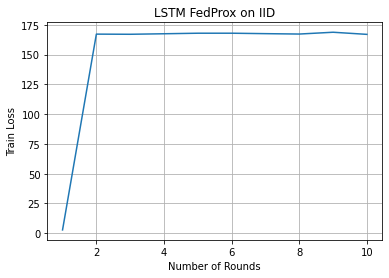

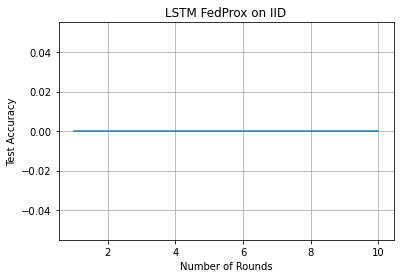

In [ ]:
exp_history = list()
for run_id in range(1):  # TOTAL RUNS
    print(f'============== RUNNING EXPERIMENT #{run_id} ==============')
    exp_history.append(run_experiment(run_id))
    print(f'\n\n========================================================\n\n')

In [ ]:
exp_log[title] = {
    'history': exp_history,
    'hyperparams': hparams.__dict__
}

In [ ]:
df = None
for i, e in enumerate(exp_history):
    if i == 0:
        df = pd.json_normalize(e)
        continue
    df = df + pd.json_normalize(e)
    
df_avg = df / len(exp_history)
avg_history = df_avg.to_dict(orient='records')

In [ ]:
plot_scores(history=avg_history, exp_id=exp_id, title=title, suffix='IID')

In [ ]:
plot_losses(history=avg_history, exp_id=exp_id, title=title, suffix='IID')

In [ ]:
with open(f'{EXP_DIR}/results_iid.pkl', 'wb') as file:
    pickle.dump(exp_log, file)

### Non-IID

In [ ]:
exp_log = dict()

In [ ]:
data_dict, test_ds = noniid_partition(corpus, seq_length=seq_length, val_split=True)

total_clients = len(data_dict.keys())
'Total users:', total_clients

Objective 413629 / 413629


('Total users:', 143)

In [ ]:
hparams = Hyperparameters(total_clients)
hparams.__dict__

{'C': 0.07,
 'E': 5,
 'K': 143,
 'batch_size': 10,
 'lr': 0.8,
 'mu': 0.001,
 'percentage': 0,
 'rounds': 10,
 'target_test_accuracy': 99.0}

In [ ]:
# Sweeping parameter
PARAM_NAME = 'clients_fraction'
PARAM_VALUE = hparams.C
exp_id = f'{PARAM_NAME}/{PARAM_VALUE}'
exp_id

'clients_fraction/0.07'

In [ ]:
EXP_DIR = f'{BASE_DIR}/{exp_id}'
os.makedirs(EXP_DIR, exist_ok=True)

# tb_logger = SummaryWriter(log_dir)
# print(f'TBoard logger created at: {log_dir}')

title = 'LSTM FedProx on Non-IID'

In [ ]:
def run_experiment(run_id):

    shakespeare_lstm = ShakespeareLSTM(input_dim=seq_length,
                                       embedding_dim=embedding_dim,
                                       hidden_dim=hidden_dim,
                                       classes=num_classes,
                                       lstm_layers=lstm_layers,
                                       dropout=dropout,
                                       batch_first=True
                                       )

    if torch.cuda.is_available():
        shakespeare_lstm.cuda()

    test_history = []

    lstm_non_iid_trained, test_history = training(shakespeare_lstm,
                                                  hparams.rounds, hparams.batch_size, hparams.lr,
                                                  None, #  ds empty as it is included in data_dict
                                                  data_dict,
                                                  test_ds,
                                                  hparams.C, hparams.K, hparams.E, hparams.mu, hparams.percentage,
                                                  title, "green",
                                                  hparams.target_test_accuracy,
                                                  corpus, # classes
                                                  history=test_history,
                                                  # tb_logger=tb_writer
                                                   )

    

    final_scores = testing(lstm_non_iid_trained, test_ds, batch_size * 2, nn.CrossEntropyLoss(), len(corpus), corpus)
    print(f'\n\n========================================================\n\n')
    print(f'Final scores for Exp {run_id} \n {final_scores}')

    log = {
        'history': test_history,
        'hyperparams': hparams.__dict__
    }

    with open(f'{EXP_DIR}/results_niid_{run_id}.pkl', 'wb') as file:
        pickle.dump(log, file)

    return test_history


============== RUNNING EXPERIMENT #0 ==============
System heterogeneity set to 0% stragglers.

Picking 10 random clients per round.

Clients: 10/143 -> [117  19  82  97  56  12 131  65  66  18]


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:662: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:915.)
  self.dropout, self.training, self.bidirectional, self.batch_first)



Round: 1... 	Average Loss: 3.101
running validation...



Test Loss: 4.499810

F1 Score: 0.000000 (macro) 0.000000 (weighted) %


Final Test  Accuracy: 0.000 (0.0/51704.0)
Clients: 10/143 -> [ 30 117  79 128   3 138   7  45  40  48]



Round: 2... 	Average Loss: 153.154
running validation...



Test Loss: 4.499810

F1 Score: 0.000000 (macro) 0.000000 (weighted) %


Final Test  Accuracy: 0.000 (0.0/51704.0)
Clients: 10/143 -> [ 40  49  54  44   2  71  80 102 135  69]



Round: 3... 	Average Loss: 157.333
running validation...



Test Loss: 4.499810

F1 Score: 0.000000 (macro) 0.000000 (weighted) %


Final Test  Accuracy: 0.000 (0.0/51704.0)
Clients: 10/143 -> [ 78  70  96 112   5  14 101 113  37  13]



Round: 4... 	Average Loss: 160.531
running validation...



Test Loss: 4.499810

F1 Score: 0.000000 (macro) 0.000000 (weighted) %


Final Test  Accuracy: 0.000 (0.0/51704.0)
Clients: 10/143 -> [ 58 128  63  25 101 115  88  95 141  93]



Round: 5... 	Average Loss: 154.923
running validation...



Test Loss: 4.499810

F1 Score: 0.000000 (macro) 0.000000 (weighted) %


Final Test  Accuracy: 0.000 (0.0/51704.0)
Clients: 10/143 -> [ 90  87  78  67   6  47  30  57 142  93]



Round: 6... 	Average Loss: 160.786
running validation...



Test Loss: 4.499810

F1 Score: 0.000000 (macro) 0.000000 (weighted) %


Final Test  Accuracy: 0.000 (0.0/51704.0)
Clients: 10/143 -> [ 15  61 105  26 124 140  42  96 112  65]



Round: 7... 	Average Loss: 164.863
running validation...



Test Loss: 4.499810

F1 Score: 0.000000 (macro) 0.000000 (weighted) %


Final Test  Accuracy: 0.000 (0.0/51704.0)
Clients: 10/143 -> [ 55 101  58  18  91  79 106  60 130 114]



Round: 8... 	Average Loss: 149.7
running validation...



Test Loss: 4.499810

F1 Score: 0.000000 (macro) 0.000000 (weighted) %


Final Test  Accuracy: 0.000 (0.0/51704.0)
Clients: 10/143 -> [ 76 102 135 130  26 101  43  11 123  82]



Round: 9... 	Average Loss: 164.628
running validation...



Test Loss: 4.499810

F1 Score: 0.000000 (macro) 0.000000 (weighted) %


Final Test  Accuracy: 0.000 (0.0/51704.0)
Clients: 10/143 -> [ 12  92  22  83 127  14  27  82  77  31]



Round: 10... 	Average Loss: 148.657
running validation...



Test Loss: 4.499810

F1 Score: 0.000000 (macro) 0.000000 (weighted) %


Final Test  Accuracy: 0.000 (0.0/51704.0)
Training Done! Total time taken to Train: 2772.7320375442505
running validation...



Test Loss: 4.499810

F1 Score: 0.000000 (macro) 0.000000 (weighted) %


Final Test  Accuracy: 0.000 (0.0/51704.0)




Final scores for Exp 0 
 {'loss': 4.499809741973877, 'accuracy': 0.0, 'f1_macro': 0.0, 'f1_weighted': 0.0}






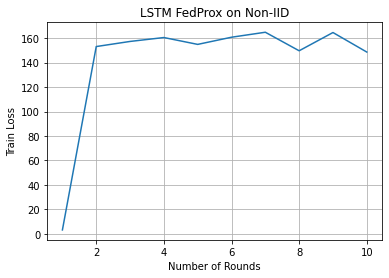

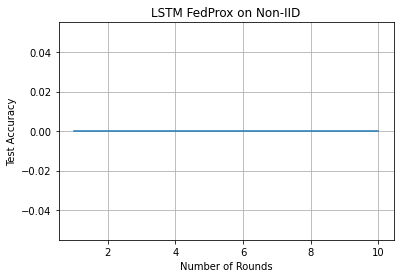

In [ ]:
exp_history = list()
for run_id in range(1):  # TOTAL RUNS
    print(f'============== RUNNING EXPERIMENT #{run_id} ==============')
    exp_history.append(run_experiment(run_id))
    print(f'\n\n========================================================\n\n')

In [ ]:
exp_log[title] = {
    'history': exp_history,
    'hyperparams': hparams.__dict__
}

In [ ]:
df = None
for i, e in enumerate(exp_history):
    if i == 0:
        df = pd.json_normalize(e)
        continue
    df = df + pd.json_normalize(e)
    
df_avg = df / len(exp_history)
avg_history = df_avg.to_dict(orient='records')

In [ ]:
plot_scores(history=avg_history, exp_id=exp_id, title=title, suffix='nonIID')

In [ ]:
plot_losses(history=avg_history, exp_id=exp_id, title=title, suffix='nonIID')

### Pickle Experiment Results

In [ ]:
with open(f'{EXP_DIR}/Shakespeare_FedProx_stragglers0_1.pkl', 'wb') as file:
    pickle.dump(exp_log, file)